In [4]:
# Import Libs
import time
init_time = time.time()

import os
import pickle
import numpy as np
import ROOT

from functions import HistogramFunctions,AuxiliarFunctions,FigureFunctions,FitFunctions,rootnotes

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 20

current_time = time.time()
print 'Time to import libraries: %1.3f seconds'%(current_time-init_time)


Time to import libraries: 0.002 seconds


In [18]:
# Read Data

from keras.utils import np_utils

init_time = time.time()

from sklearn import datasets

output = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/DataFiles"

# import some data to play with

signal = np.load(output+"/"+"lvbb125Matrix.npy")[0:5000,:]
trgt_signal = np.ones(signal.shape[0])

all_signal = np.load(output+"/"+"lvbb125Matrix.npy")


ZZ = np.load(output+"/"+"ZZMatrix.npy")[0:5000,:]
trgt_ZZ = -1*np.ones(ZZ.shape[0])

all_ZZ = np.load(output+"/"+"ZZMatrix.npy")

background=ZZ
trgt_bkg=trgt_ZZ

all_background = all_ZZ 

data_colors = ['b','r']
data_labels = ['signal','background']

data=np.append(signal,background,axis=0)
trgt=np.append(trgt_signal,trgt_bkg,axis=0)

all_data=np.append(all_signal,all_background,axis=0)


# for classification -> target max sparse
#trgt_sparse = np_utils.to_categorical(trgt_sinal)

current_time = time.time()
#print 'Time to import data: %1.3f seconds'%(current_time-init_time)
#print "Sinal", signal.shape
#print "ZZ", ZZ.shape
print data.shape
print trgt.shape


(10000, 24)
(10000,)


In [10]:
# Train a classifier

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils

from sklearn import cross_validation
from sklearn import preprocessing

n_folds = 2
n_inits = 2
norm = 'mapstd'

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

classifiers = {}

for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if norm == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif norm == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif norm == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
    norm_data = scaler.transform(data)
    
    best_init = 0
    best_loss = 999
    
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        model = Sequential()
        model.add(Dense(data.shape[1],
                        input_dim=data.shape[1],
                        init='identity',
                        trainable=False))
        model.add(Activation('linear'))
        model.add(Dense(10, input_dim=data.shape[1], 
                        init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(1,
                        init='uniform')) 
        model.add(Activation('tanh'))
        
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.7)
        model.compile(loss='mean_squared_error',
                      optimizer=sgd,
                      metrics=['accuracy'])
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=25, 
                                                verbose=0, 
                                                mode='auto')
        # Train model
        init_trn_desc = model.fit(data[train_id], 
                                  trgt[train_id], 
                                  nb_epoch=50, 
                                  batch_size=8, 
                                  callbacks=[earlyStopping], 
                                  verbose=True, 
                                  validation_data=(data[test_id],
                                                   trgt[test_id]), 
                                  shuffle=True)
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifiers[ifold] = model

Processing: Fold 1 of 2 Init 1 of 2
Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 0s - loss: 1.9004 - acc: 0.4606 - val_loss: 2.0000 - val_acc: 0.5000
Epoch 2/50
5000/5000 [==============================] - 0s - loss: 2.0000 - acc: 0.5000 - val_loss: 2.0000 - val_acc: 0.5000

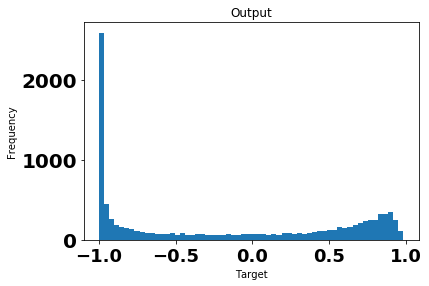

In [20]:
# analyse train process - output distribution
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

plt.hist(output,60)
plt.title("Output")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()

#n_rows = trgt.shape[1]
#n_columns = output.shape[1]

#fig, ax = plt.subplots(figsize=(20,20),nrows=n_rows, ncols=n_columns)
#m_bins = np.linspace(-1., 1., 50)


#irow = 0
#icolumn = 0
#for itarget in range(trgt_sparse.shape[1]):
#    for ioutput in range(output.shape[1]):
#        m_pts = output[trgt==itarget,ioutput]
#        n, bins, patches = (ax[irow,icolumn].hist(m_pts,bins=m_bins,
                                                      #fc=iris_colors[itarget],
                                                      #alpha=0.8, normed=1))
#        for tick in ax[irow,icolumn].get_xticklabels():
#            tick.set_rotation(45)
#        ax[irow,icolumn].grid()
    
#        if irow == 0:
#            ax[irow,icolumn].set_title('Output for Neuron %i'%(ioutput+1),
#                                       fontweight='bold',fontsize=15)
#        if icolumn == 0:
#            ax[irow,icolumn].set_ylabel('Class %s'%(iris_labels[itarget]),
#                                        fontweight='bold',fontsize=15)
#        if irow == n_rows-1:
#            ax[irow,icolumn].set_xlabel('Possible Values',
#                                        fontweight='bold',fontsize=15)
    
        
#        if icolumn+1 == n_columns:
#            icolumn = 0
#            irow = irow+1
#        else:
#            icolumn = icolumn+1

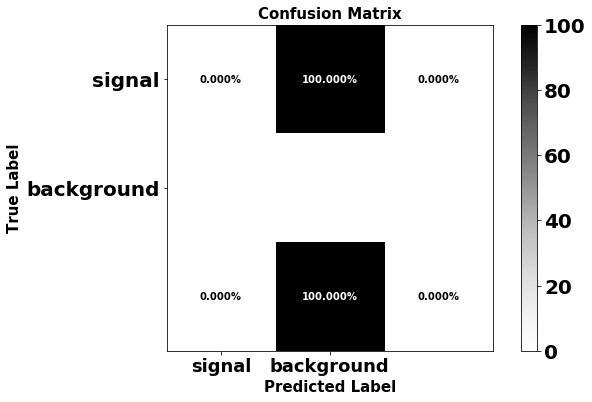

In [14]:
# analyse train process - confusion matrix
from sklearn.metrics import confusion_matrix

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

cm = confusion_matrix(trgt[test_id], output_class[test_id])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape

for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)